In [41]:
# conda environment: "fepenv", python version=3.12.7

import pandas as pd
import sys
import biotite.database.rcsb as rcsb
from Bio.PDB.MMCIF2Dict import MMCIF2Dict
import urllib.request
import pypdb
import os
import tqdm
import warnings
import pypdb
import redo
import matplotlib.pyplot as plt
import numpy as np


from IPython.display import display, HTML
import ipywidgets as widgets

from chembl_webresource_client.new_client import new_client


# Querying PDB based on methodological/protein requirements using biotite

In [2]:
# https://search.rcsb.org/structure-search-attributes.html

# Methodology
experimental_method = "X-ray"
resolution_combined = 3.5
deposition_date = "2010-01-01T00:00:00Z"

# Protein characteristics
membrane_annotations = ['PDBTM', 'MemProtMD'] # 'PDBTM', 'OPM', 'MemProtMD', 'mpstruc'
organism = "Homo sapiens"

# Ligand characteristics
min_ligand_molecular_weight = 100
ligand_binding_type = "HAS_NO_COVALENT_LINKAGE"
ligand_binding_class = "Antagonist" # doesn't seem to be annotated in (nearly) any structure mmCIFs

In [3]:
query_by_experimental_method = rcsb.FieldQuery(
    "rcsb_entry_info.experimental_method",
    exact_match=experimental_method
)

query_by_resolution = rcsb.FieldQuery(
    "rcsb_entry_info.resolution_combined",
    less_or_equal=resolution_combined
)

query_by_deposition_date = rcsb.FieldQuery(
    "rcsb_accession_info.deposit_date", 
    greater=deposition_date
)

query_by_ligand_mw = rcsb.FieldQuery(
    "chem_comp.formula_weight",
    molecular_definition=True,
    greater=min_ligand_molecular_weight
)

query_by_membrane_annotation = rcsb.FieldQuery(
    "rcsb_polymer_entity_annotation.type",
    is_in=membrane_annotations
)

query_by_organism = rcsb.FieldQuery(
    "rcsb_entity_source_organism.scientific_name",
    exact_match=organism
)

query_by_ligand_binding_type = rcsb.FieldQuery(
    "rcsb_nonpolymer_instance_annotation.type",
    exact_match=ligand_binding_type
)

# query_by_ligand_class = rcsb.FieldQuery(
#     "pdbx_molecule_features.class",
#     exact_match=ligand_binding_class
# )

In [4]:
query = rcsb.CompositeQuery(
    [
        query_by_resolution,
        query_by_experimental_method,
        query_by_membrane_annotation,
        query_by_organism,
        query_by_ligand_mw,
        query_by_ligand_binding_type,
        query_by_deposition_date, 
    ],
    "and",
)

pdb_ids = rcsb.search(query)
print(f"{len(pdb_ids)} matches:")
print(pdb_ids)

# 2.0 Ä -> ~50-60 matches
# 2.5 Ä -> ~180 matches
# 3.0 Ä -> ~400 matches
# 3.5 Ä -> ~570 matches

574 matches:
['2XCG', '2XFN', '2XFO', '2XFP', '2XFQ', '2YDO', '2YDV', '3B29', '3LEO', '3NY8', '3NY9', '3NYA', '3ODU', '3OE6', '3OE8', '3OE9', '3P0G', '3PBL', '3PCV', '3PDS', '3PO7', '3PWH', '3REY', '3RZE', '3SN6', '3UKM', '3UM7', '3UON', '3UZA', '3UZC', '3V2W', '3V2Y', '3V8X', '3VG9', '3VGA', '3VW7', '3ZDQ', '3ZYX', '4A79', '4A7A', '4AL0', '4AL1', '4AW6', '4AYT', '4AYW', '4AYX', '4BPM', '4BW5', '4COF', '4DCB', '4DJH', '4EA3', '4EIY', '4G7V', '4G7Y', '4I9W', '4IAQ', '4IAR', '4IB4', '4J7T', '4J7Y', '4JC7', '4JCZ', '4JKV', '4JRZ', '4K5Y', '4KFM', '4L6R', '4LDE', '4LDL', '4LDO', '4MBS', '4MQS', '4N4W', '4N6H', '4NC3', '4NEF', '4NTJ', '4O9R', '4OO9', '4OR2', '4PHU', '4PXZ', '4PY0', '4PYP', '4QIM', '4QIN', '4QKX', '4RUE', '4RUF', '4RWA', '4RWD', '4S0V', '4TWK', '4UG2', '4UHR', '4WAB', '4WFE', '4WFF', '4WFG', '4WFH', '4WO1', '4WOL', '4X5T', '4XDL', '4XNV', '4XNW', '4XT1', '4YAY', '4YK5', '4YL0', '4YL1', '4YL3', '4Z34', '4Z35', '4Z36', '4Z9G', '4ZJ8', '4ZJC', '4ZUD', '4ZW9', '4ZWC', '4ZYO', '5

# Downloading `.pdb` and `.cif` file for selected PDB entries with pypdb

In [5]:
# def download_pdb_cif_from_pdbid(pdb_id):
#     folder_name = "proteins"
#     file_path = os.path.join(folder_name, pdb_id)
#     os.makedirs(folder_name, exist_ok=True)

#     warnings.simplefilter("ignore") # ignore deprecation warning
#     cifstring = pypdb.get_pdb_file(pdb_id, filetype='cif', compression=False)
#     with open((file_path+".cif"), "w") as file:
#         file.write(cifstring)

#     warnings.simplefilter("ignore") # ignore deprecationwarning
#     pdbstring = pypdb.get_pdb_file(pdb_id, filetype="pdb", compression=False)
#     with open((file_path+".pdb"), "w") as file:
#         file.write(pdbstring)


# def download_pdb_cif_from_pdbid(pdb_id):
#     folder_name = "proteins"
#     file_path = os.path.join(folder_name, pdb_id)
#     os.makedirs(folder_name, exist_ok=True)

#     print(f"Downloading and saving to {file_path}")

#     try:
#         # Fetch and save CIF file
#         warnings.simplefilter("ignore")  # Ignore deprecation warnings
#         cifstring = pypdb.get_pdb_file(pdb_id, filetype='cif', compression=False)
#         if cifstring:
#             with open((file_path + ".cif"), "w") as file:
#                 file.write(cifstring)
#         else:
#             print(f"CIF file is None for PDB ID {pdb_id}, skipping.")

#         # Fetch and save PDB file
#         pdbstring = pypdb.get_pdb_file(pdb_id, filetype="pdb", compression=False)
#         if pdbstring:
#             with open((file_path + ".pdb"), "w") as file:
#                 file.write(pdbstring)
#         else:
#             print(f"PDB file is None for PDB ID {pdb_id}, skipping.")

#     except TypeError as e:
#         print(f"TypeError for PDB ID {pdb_id}: {e}. Skipping.")
#     except Exception as e:
#         print(f"An unexpected error occurred for PDB ID {pdb_id}: {e}. Skipping.")

In [6]:
def download_pdb_cif_from_pdbid(pdb_id):
    folder_name = "proteins"
    file_path = os.path.join(folder_name, pdb_id)
    os.makedirs(folder_name, exist_ok=True)

    cif_file_path = file_path + ".cif"
    pdb_file_path = file_path + ".pdb"

    # Check if files already exist
    if os.path.exists(cif_file_path):
        print(f"CIF file for PDB ID {pdb_id} already exists, skipping download.")
    if os.path.exists(pdb_file_path):
        print(f"PDB file for PDB ID {pdb_id} already exists, skipping download.")

    # Download only if necessary
    try:
        # Fetch and save CIF file if not already downloaded
        if not os.path.exists(cif_file_path):
            warnings.simplefilter("ignore")  # Ignore deprecation warnings
            cifstring = pypdb.get_pdb_file(pdb_id, filetype='cif', compression=False)
            if cifstring:
                with open(cif_file_path, "w") as file:
                    file.write(cifstring)
                print(f"CIF file downloaded and saved to {cif_file_path}")
            else:
                print(f"CIF file is None for PDB ID {pdb_id}, skipping.")

        # Fetch and save PDB file if not already downloaded
        if not os.path.exists(pdb_file_path):
            pdbstring = pypdb.get_pdb_file(pdb_id, filetype="pdb", compression=False)
            if pdbstring:
                with open(pdb_file_path, "w") as file:
                    file.write(pdbstring)
                print(f"PDB file downloaded and saved to {pdb_file_path}")
            else:
                print(f"PDB file is None for PDB ID {pdb_id}, skipping.")

    except TypeError as e:
        print(f"TypeError for PDB ID {pdb_id}: {e}. Skipping.")
    except Exception as e:
        print(f"An unexpected error occurred for PDB ID {pdb_id}: {e}. Skipping.")

In [7]:
for pdb_id in tqdm.tqdm(pdb_ids):
    download_pdb_cif_from_pdbid(pdb_id);

  0%|          | 0/574 [00:00<?, ?it/s]/opt/anaconda3/envs/fepenv/lib/python3.12/site-packages/pypdb/pypdb.py:497: DeprecationWarning: The `get_pdb_file` function within pypdb.py is deprecated.See `pypdb/clients/pdb/pdb_client.py` for a near-identical function to use
  warnings.warn(


CIF file for PDB ID 2XCG already exists, skipping download.
PDB file for PDB ID 2XCG already exists, skipping download.
CIF file for PDB ID 2XFN already exists, skipping download.
PDB file for PDB ID 2XFN already exists, skipping download.
CIF file for PDB ID 2XFO already exists, skipping download.
PDB file for PDB ID 2XFO already exists, skipping download.
CIF file for PDB ID 2XFP already exists, skipping download.
PDB file for PDB ID 2XFP already exists, skipping download.
CIF file for PDB ID 2XFQ already exists, skipping download.
PDB file for PDB ID 2XFQ already exists, skipping download.
CIF file for PDB ID 2YDO already exists, skipping download.
PDB file for PDB ID 2YDO already exists, skipping download.
CIF file for PDB ID 2YDV already exists, skipping download.
PDB file for PDB ID 2YDV already exists, skipping download.
CIF file for PDB ID 3B29 already exists, skipping download.
PDB file for PDB ID 3B29 already exists, skipping download.
CIF file for PDB ID 3LEO already exists,

/opt/anaconda3/envs/fepenv/lib/python3.12/site-packages/pypdb/util/http_requests.py:65: UserWarning: Too many failures on requests. Exiting...
  warnings.warn("Too many failures on requests. Exiting...")
/opt/anaconda3/envs/fepenv/lib/python3.12/site-packages/pypdb/clients/pdb/pdb_client.py:83: UserWarning: Retrieval failed, returning None
  warnings.warn("Retrieval failed, returning None")
  9%|▊         | 50/574 [00:06<01:07,  7.74it/s]

PDB file is None for PDB ID 4DCB, skipping.
CIF file for PDB ID 4DJH already exists, skipping download.
PDB file for PDB ID 4DJH already exists, skipping download.
CIF file for PDB ID 4EA3 already exists, skipping download.
PDB file for PDB ID 4EA3 already exists, skipping download.
CIF file for PDB ID 4EIY already exists, skipping download.
PDB file for PDB ID 4EIY already exists, skipping download.
CIF file for PDB ID 4G7V already exists, skipping download.
PDB file for PDB ID 4G7V already exists, skipping download.
CIF file for PDB ID 4G7Y already exists, skipping download.
PDB file for PDB ID 4G7Y already exists, skipping download.
CIF file for PDB ID 4I9W already exists, skipping download.
PDB file for PDB ID 4I9W already exists, skipping download.
CIF file for PDB ID 4IAQ already exists, skipping download.
PDB file for PDB ID 4IAQ already exists, skipping download.
CIF file for PDB ID 4IAR already exists, skipping download.
PDB file for PDB ID 4IAR already exists, skipping downlo

 99%|█████████▊| 566/574 [00:10<00:00, 64.46it/s]

PDB file downloaded and saved to proteins/8RW0.pdb
CIF file for PDB ID 8T1V already exists, skipping download.
PDB file for PDB ID 8T1V already exists, skipping download.
CIF file for PDB ID 8T1W already exists, skipping download.
PDB file for PDB ID 8T1W already exists, skipping download.
CIF file for PDB ID 8TF5 already exists, skipping download.
PDB file for PDB ID 8TF5 already exists, skipping download.
CIF file for PDB ID 8TGY already exists, skipping download.
PDB file for PDB ID 8TGY already exists, skipping download.
CIF file for PDB ID 8TZI already exists, skipping download.
PDB file for PDB ID 8TZI already exists, skipping download.
CIF file for PDB ID 8VXU already exists, skipping download.
PDB file for PDB ID 8VXU already exists, skipping download.
CIF file for PDB ID 8WDT already exists, skipping download.
PDB file for PDB ID 8WDT already exists, skipping download.
Sending GET request to https://files.rcsb.org/download/9FUP.cif to fetch 9FUP's cif file as a string.
CIF fil

100%|██████████| 574/574 [00:15<00:00, 37.80it/s]

PDB file downloaded and saved to proteins/9FUP.pdb


In [8]:
# from https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T008_query_pdb/talktorial.ipynb
@redo.retriable(attempts=10, sleeptime=2)
def describe_one_pdb_id(pdb_id):
    """Fetch meta information from PDB."""
    described = pypdb.describe_pdb(pdb_id)
    if described is None:
        print(f"! Error while fetching {pdb_id}, retrying ...")
        raise ValueError(f"Could not fetch PDB id {pdb_id}")
    return described

In [9]:
pdbs_data = [describe_one_pdb_id(pdb_id) for pdb_id in tqdm.tqdm(pdb_ids)]

100%|██████████| 574/574 [03:12<00:00,  2.98it/s]


# Quality assessment of X-ray crystallography structures
Based on the guidelines of [Hahn et al. 2022](https://doi.org/10.33011/livecoms.4.1.1497).

**Overfit structure**
To identify an *overfit structure*, the difference of [R and Rfree residual factors](https://en.wikipedia.org/wiki/R-factor_(crystallography)) exceeds 0.05. (p.8 Hahn 2022)

**Coordinate error**
High quality structures should have a coordinate error (ESU R_free) < 0.07 (p.8 Hahn 2022), this is the same advisory boundary as defined in the [mmCIF dictionary](https://mmcif.wwpdb.org/dictionaries/mmcif_pdbx_v50.dic/Items/_refine.pdbx_overall_ESU_R_Free.html).

In [10]:
structures = pd.DataFrame(
    [
        [
            pdb_data.get("entry", {}).get("id", None),
            pdb_data.get("rcsb_entry_info", {}).get("resolution_combined", [None])[0],
            pdb_data.get("refine", [{}])[0].get("ls_rfactor_obs", None),
            pdb_data.get("refine", [{}])[0].get("ls_rfactor_rfree", None),
            pdb_data.get("refine", [{}])[0].get("pdbx_overall_esurfree", None)

        ]
        for pdb_data in pdbs_data
    ],
    columns=["pdb_id", "resolution", "R-factor", "R-free-factor", "Coordinate_Error_(ESU_Rfree)"]
).sort_values(by="resolution")

In [11]:
# Hahn et al. 2022, p. 8 (https://doi.org/10.33011/livecoms.4.1.1497)

structures['R/Rfree diff'] = np.abs(structures['R-free-factor'] - structures['R-factor'])
structures['R/Rfree_overfit'] = structures['R/Rfree diff'] > 0.05
structures

,pdb_id,resolution,R-factor,R-free-factor,Coordinate_Error_(ESU_Rfree),R/Rfree diff,R/Rfree_overfit
40,4AL0,1.16,0.12231,0.12964,0.020,0.00733,False
217,5TL9,1.20,0.15280,0.16801,0.028,0.01521,False
162,5K0I,1.30,0.14619,0.15917,0.032,0.01298,False
437,6VL4,1.40,0.13980,0.14500,0.007,0.00520,False
211,5T36,1.40,0.18415,0.19483,0.048,0.01068,False
...,...,...,...,...,...,...,...
16,3P0G,3.50,0.24280,0.30830,NaN,0.06550,True
433,6V9S,3.50,0.24150,0.27320,NaN,0.03170,False
103,4X5T,3.50,0.25430,0.27000,NaN,0.01570,False
72,4MQS,3.50,0.25440,0.29820,NaN,0.04380,False


In [12]:
print(f"Number of entries: {structures.shape[0]}")
print(f"Number of entries with R/Rfree overfit (difference > 0.05): {structures[structures['R/Rfree_overfit'] == True].shape[0]}")
print(f"Number of entries with missing values: {structures.isnull().sum().sum()}")
print(f"Number of entries with coordinate error >= 0.7: {structures[structures['Coordinate_Error_(ESU_Rfree)'] >= 0.7].shape[0]} \n")

structuresfiltered = structures.dropna()
structuresfiltered = structuresfiltered[structuresfiltered['R/Rfree_overfit'] != True]
structuresfiltered = structuresfiltered[structuresfiltered['Coordinate_Error_(ESU_Rfree)'] < 0.7]

print(f"Number of entries in filtered set: {structuresfiltered.shape[0]}")

Number of entries: 574
Number of entries with R/Rfree overfit (difference > 0.05): 45
Number of entries with missing values: 471
Number of entries with coordinate error >= 0.7: 0 

Number of entries in filtered set: 110


# Relation between quality metrics

## Pre-filter

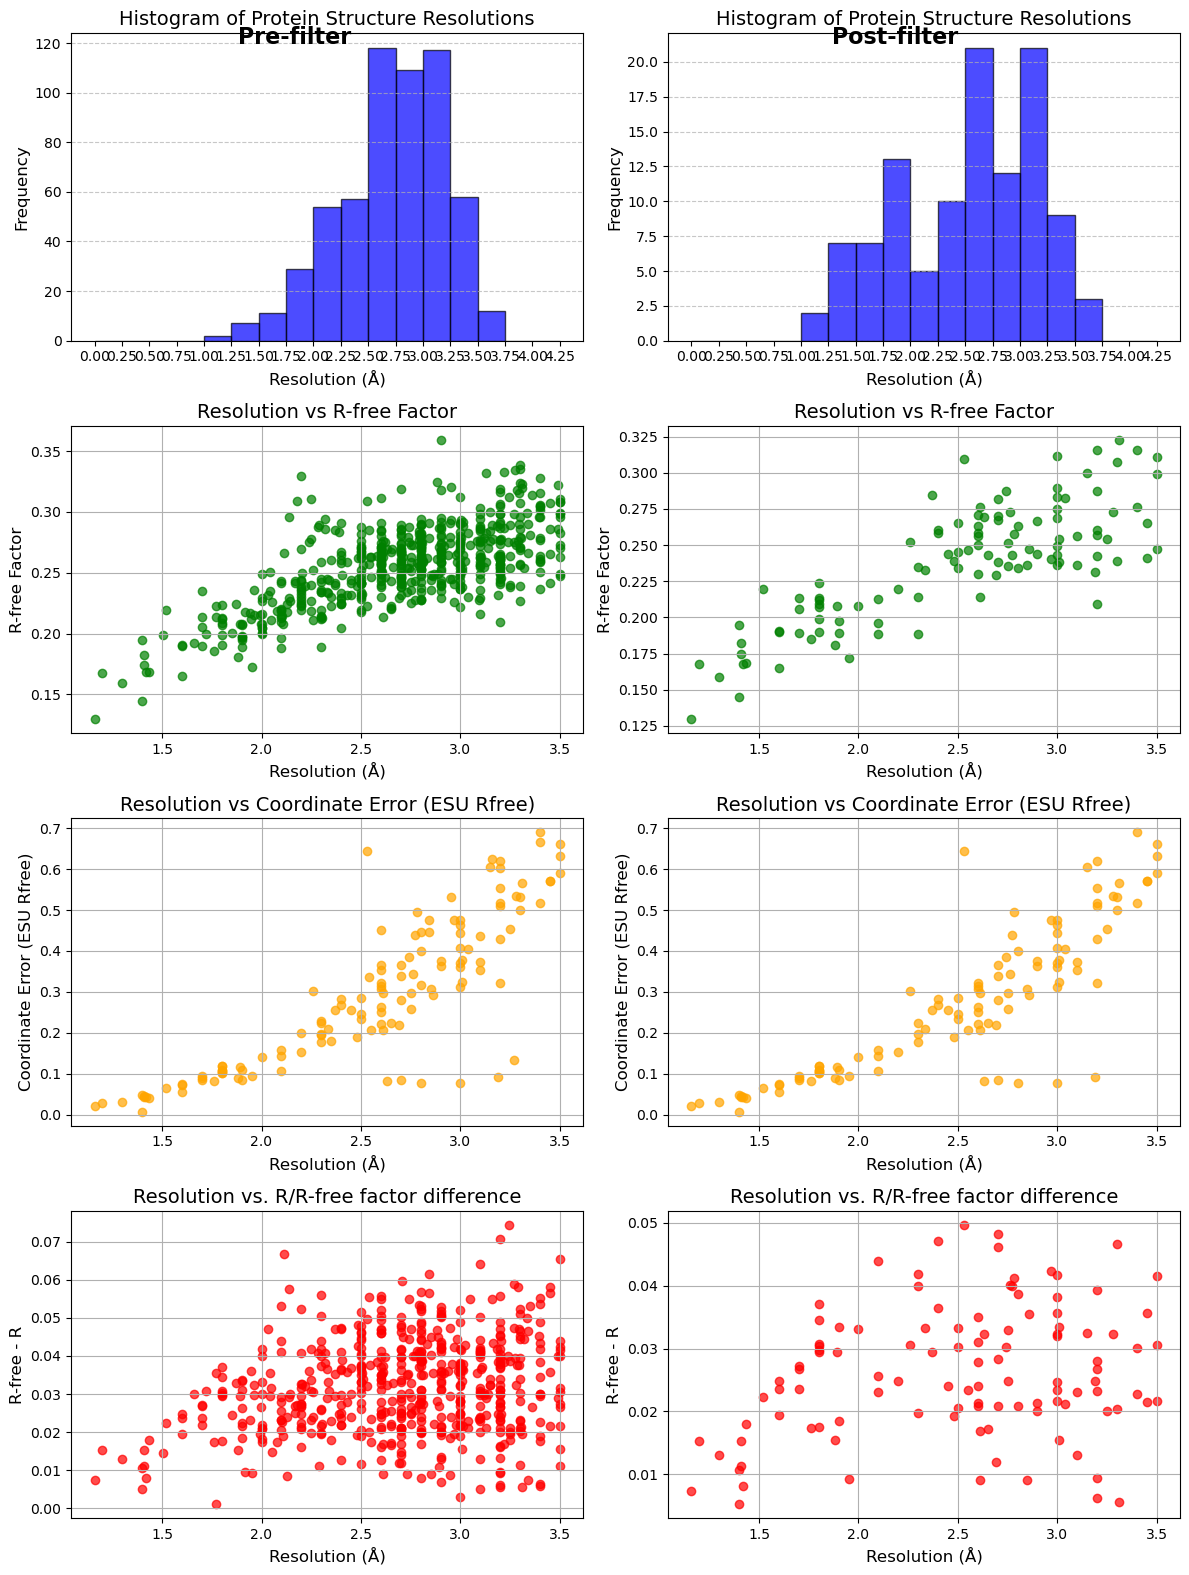

In [13]:
import numpy as np
import matplotlib.pyplot as plt

bins = np.arange(0, 4.5, 0.25)

# Create a single figure with 8 subplots arranged in 2 columns and 4 rows
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
axes = axes.flatten()

# Add column titles
fig.suptitle("", x=0.5, fontsize=16)
fig.text(0.25, 0.96, "Pre-filter", ha='center', fontsize=16, fontweight='bold')
fig.text(0.75, 0.96, "Post-filter", ha='center', fontsize=16, fontweight='bold')

# Left 1
axes[0].hist(structures['resolution'], bins=bins, edgecolor='black', alpha=0.7, color='blue')
axes[0].set_title('Histogram of Protein Structure Resolutions', fontsize=14)
axes[0].set_xlabel('Resolution (Å)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_xticks(bins)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Left 2
axes[2].scatter(structures['resolution'], structures['R-free-factor'], color='green', alpha=0.7)
axes[2].set_title('Resolution vs R-free Factor', fontsize=14)
axes[2].set_xlabel('Resolution (Å)', fontsize=12)
axes[2].set_ylabel('R-free Factor', fontsize=12)
axes[2].grid(True)

# Left 3
axes[4].scatter(structures['resolution'], structures['Coordinate_Error_(ESU_Rfree)'], color='orange', alpha=0.7)
axes[4].set_title('Resolution vs Coordinate Error (ESU Rfree)', fontsize=14)
axes[4].set_xlabel('Resolution (Å)', fontsize=12)
axes[4].set_ylabel('Coordinate Error (ESU Rfree)', fontsize=12)
axes[4].grid(True)

# Left 4
axes[6].scatter(structures['resolution'], structures['R/Rfree diff'], color='red', alpha=0.7)
axes[6].set_title('Resolution vs. R/R-free factor difference', fontsize=14)
axes[6].set_xlabel('Resolution (Å)', fontsize=12)
axes[6].set_ylabel('R-free - R', fontsize=12)
axes[6].grid(True)



axes[1].hist(structuresfiltered['resolution'], bins=bins, edgecolor='black', alpha=0.7, color='blue')
axes[1].set_title('Histogram of Protein Structure Resolutions', fontsize=14)
axes[1].set_xlabel('Resolution (Å)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_xticks(bins)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Right 2
axes[3].scatter(structuresfiltered['resolution'], structuresfiltered['R-free-factor'], color='green', alpha=0.7)
axes[3].set_title('Resolution vs R-free Factor', fontsize=14)
axes[3].set_xlabel('Resolution (Å)', fontsize=12)
axes[3].set_ylabel('R-free Factor', fontsize=12)
axes[3].grid(True)

# Right 3
axes[5].scatter(structuresfiltered['resolution'], structuresfiltered['Coordinate_Error_(ESU_Rfree)'], color='orange', alpha=0.7)
axes[5].set_title('Resolution vs Coordinate Error (ESU Rfree)', fontsize=14)
axes[5].set_xlabel('Resolution (Å)', fontsize=12)
axes[5].set_ylabel('Coordinate Error (ESU Rfree)', fontsize=12)
axes[5].grid(True)

axes[7].scatter(structuresfiltered['resolution'], structuresfiltered['R/Rfree diff'], color='red', alpha=0.7)
axes[7].set_title('Resolution vs. R/R-free factor difference', fontsize=14)
axes[7].set_xlabel('Resolution (Å)', fontsize=12)
axes[7].set_ylabel('R-free - R', fontsize=12)
axes[7].grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


# Assessing the quality of protein structure files for FEP

In this protein screening effort, it was chosen to largely adapt the guidelines given by Hahn et al. (2022) to assess the quality of the experimental structures.

## Resolution and its impact on FEP prediction accuracy in the literature
The first metric to consider is the resolution of the experimental structure, which reflects the smallest distance at which separate atoms can be distinguished. In principle, the higher the resolution (meaning a smaller value in Å), the better. While there do not seem to be any definite resolution thresholds at which point a structure is deemed unusable for FEP, Hahn et al. (2022) reports that different cut-offs have been suggested of 3.5, or even 2.0 Å.

The large scale FEP study of Schindler et al. (2020) could not, however, find any correlation between the resolution of the used structures, and the accurracy of binding affinity predictions in a validation FEP study on 14 targets, while using structures with a resolution range of 1.65 - 2.35 Å. Furthermore, various FEP studies on GPCR targets in the literature (and which will be included in the QligFEP validation study in this project) used structures featuring resolutions above 2.0 and still attained good binding free energy predictions (< 1 kcal / mol RMSD) (Deflorian 2020, Dickson 2021, Panel 2023). This indicates that a strict, absolute resolution cut-off at 2.0 Å would not be productive since it would exclude many potentially interesting transmembranal protein targets while its effect on assuring accurate predictions is not reliable. 

Furthermore, it should be understood that the crystallographic structure is only a static *model* of the real protein structure. During molecular dynamics simulations, the protein-ligand complex will move dynamically as predicted by the intra- and intermolecular forces calculated based on the chosen force field. The widespread reporting of lower resolution structures still allowing for accurate free energy estimations during MD / FEP simulations seems to indicate that these methods are robust to the small positional inaccuracies resulting from these structures' resolution. 

*Caveat*: one substantial benefit of higher resolution structures is the co-crystallization of binding site water molecules, whose role in influencing the binding of ligands is deemed to be important, for instance by forming hydrogen bonds ([Lu et al. 2007](https://pubs.acs.org/doi/10.1021/ci6003527)). Ideally, these binding site water molecules would be included in the structure model. When assessing a experimental structure for FEP, a manual inspection of the atom density of the binding site should be performed to identify any missing water molecules.

## R, Rfree, and coordinate error

The [R-factor](https://en.wikipedia.org/wiki/R-factor_(crystallography)) is a measure of how well the experimental X-ray diffraction data agrees with the crystallographic model. During refinement and rebuilding of the atomic model, both the atomic model and experimental diffraction data is used, which introduces bias (https://pdb101.rcsb.org/learn/guide-to-understanding-pdb-data/crystallographic-data), therefore the Rfree factor can be used. Rfree is calculated similarly, but on a random subset of the experimental data. If the R- and R-free-factors are substantially different (Hahn et. al 2022 uses a threshold of Rfree - R > 0.05), it could imply an overfit model. 

The coordinate error is another calculated metric which Hahn et al. 2022 describes as "the best way to assess the precision and quality of the model". The threshold defined by Hahn et al. 2022 is < 0.07, which is the same advisory boundary condition as defined in the [mmCIF dictionary](https://mmcif.wwpdb.org/dictionaries/mmcif_pdbx_v50.dic/Items/_refine.pdbx_overall_ESU_R_Free.html).



# To-do

Write and work out following discussions + actions to assess eligibility of potential TM protein target:

### 1. relation resolution ~ R/coordinate error
**As resolution increases, R-factor and coordinate error seems to increase as well. Both are structure qualities indicators.**

Even though the 'resolution' itself is not part of the R factor calculation (https://en.wikipedia.org/wiki/R-factor_(crystallography)):
$$
R = \frac{\sum \| F_{obs}| - F_{calc}\|}{\sum | F_{obs} | }
$$

Where $F$ is the structure-factor amplitude. However, since a high-resolution structure will have more observed data, it will be less susceptible to random experimental error which contribute to the R-factor. 

The coordinate error is not independent from the R-free factor, as can be understood from its calculation:

$$
\text{coordinate error} = \frac{2.22R_{free}\sqrt{N_{i}^3}\sqrt{V_{a}}}{n_{obs}^{5/6}}
$$

### 2. Bioactivity data availability for target
There should be enough bioactivity data available for a congeneric series of ligands similar to the co-crystallized ligand.
- Automatic collection of ligand-bioactivity datapoints of ligands similar to co-crystallized ligand based on protein identifier (PDB ID/uniprot ID?)
- Necessary dynamic range? 


In [14]:
structuresfiltered

,pdb_id,resolution,R-factor,R-free-factor,Coordinate_Error_(ESU_Rfree),R/Rfree diff,R/Rfree_overfit
40,4AL0,1.16,0.12231,0.12964,0.020,0.00733,False
217,5TL9,1.20,0.15280,0.16801,0.028,0.01521,False
162,5K0I,1.30,0.14619,0.15917,0.032,0.01298,False
437,6VL4,1.40,0.13980,0.14500,0.007,0.00520,False
211,5T36,1.40,0.18415,0.19483,0.048,0.01068,False
...,...,...,...,...,...,...,...
66,4KFM,3.45,0.22960,0.26530,0.571,0.03570,False
541,8A2O,3.45,0.21970,0.24120,0.571,0.02150,False
138,5DYE,3.50,0.28036,0.31096,0.661,0.03060,False
225,5UIG,3.50,0.27719,0.29883,0.590,0.02164,False


In [18]:
def pdb_to_uniprot(pdb_id):
    pdb_id = pdb_id.lower()
    try:
        response = requests.get(f"https://www.ebi.ac.uk/pdbe/api/mappings/uniprot/{pdb_id}")

        response.raise_for_status()

        jsronResponse = response.json()
        
        uniprotID = list(jsronResponse[pdb_id]['UniProt'].keys())[0]
        uniprotNAME = jsronResponse[pdb_id]['UniProt'][uniprotID]['name']

        return uniprotID, uniprotNAME

    # except HTTPError as http_err:
    #     print(f'HTTP error occurred for PDB {pdb_id}: {http_err}')
    except Exception as err:
        print(f'Other error occurred for PDB {pdb_id}: {err}')
    
    return None, None


In [19]:
structuresfiltered[['uniprot_id', 'uniprot_name']] = structuresfiltered['pdb_id'].apply((lambda x: pd.Series(pdb_to_uniprot(x))))

Other error occurred for PDB 4al0: name 'requests' is not defined
Other error occurred for PDB 5tl9: name 'requests' is not defined
Other error occurred for PDB 5k0i: name 'requests' is not defined
Other error occurred for PDB 6vl4: name 'requests' is not defined
Other error occurred for PDB 5t36: name 'requests' is not defined
Other error occurred for PDB 4yl1: name 'requests' is not defined
Other error occurred for PDB 4yl3: name 'requests' is not defined
Other error occurred for PDB 4yk5: name 'requests' is not defined
Other error occurred for PDB 5bqg: name 'requests' is not defined
Other error occurred for PDB 4yl0: name 'requests' is not defined
Other error occurred for PDB 2xfn: name 'requests' is not defined
Other error occurred for PDB 6fw0: name 'requests' is not defined
Other error occurred for PDB 5bqh: name 'requests' is not defined
Other error occurred for PDB 6rkp: name 'requests' is not defined
Other error occurred for PDB 6fwc: name 'requests' is not defined
Other erro

In [22]:
structuresfiltered['uniprot_name'].unique()

array(['PTGES_HUMAN', 'AOFB_HUMAN', 'AA2AR_HUMAN', 'C562_ECOLX',
       'LTC4S_HUMAN', 'GPR52_HUMAN', 'KCNK4_HUMAN', 'FFAR1_HUMAN',
       'AL5AP_HUMAN', 'MFS10_HUMAN', '5HT2A_HUMAN', 'Q6J5N4_ECOLX',
       'U2EQ00_9FIRM', 'AQP5_HUMAN', 'GLRA3_HUMAN', 'Q81HW2_BACCR',
       'P2RY1_HUMAN', 'ACM1_HUMAN', 'VDAC1_HUMAN', 'ASIC1_HUMAN',
       '5HT1B_HUMAN', 'GLR_HUMAN', 'SMO_HUMAN', 'MGST2_HUMAN',
       'GPT_HUMAN', 'AA1R_HUMAN', 'GBRB3_HUMAN', 'MTR1A_HUMAN',
       'CD47_HUMAN', 'KCNJ6_MOUSE'], dtype=object)

In [21]:
# structures.to_csv('structures.csv', index=False)
# structuresfiltered.to_csv('structures_filtered.csv', index=False)

structures = pd.read_csv('structures.csv')
structuresfiltered = pd.read_csv('structures_filtered.csv')

In [67]:
structuresfiltered[structuresfiltered['uniprot_name'] == '5HT1B_HUMAN']

,pdb_id,resolution,R-factor,R-free-factor,Coordinate_Error_(ESU_Rfree),R/Rfree diff,R/Rfree_overfit,uniprot_id,uniprot_name
77,7C61,3.0,0.2541,0.2898,0.444,0.0357,False,P28222,5HT1B_HUMAN


## Bioactivity

In [42]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [68]:
uniprot_id = 'P28222'

targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(targets)

[{'organism': 'Homo sapiens', 'pref_name': 'Serotonin 1b (5-HT1b) receptor', 'target_chembl_id': 'CHEMBL1898', 'target_type': 'SINGLE PROTEIN'}, {'organism': 'Homo sapiens', 'pref_name': 'Serotonin 1 receptors; 5-HT1B & 5-HT1D', 'target_chembl_id': 'CHEMBL2095230', 'target_type': 'SELECTIVITY GROUP'}, {'organism': 'Homo sapiens', 'pref_name': 'Serotonin (5-HT) receptor', 'target_chembl_id': 'CHEMBL2096904', 'target_type': 'PROTEIN FAMILY'}, {'organism': 'Homo sapiens', 'pref_name': '5-HT1B/5-HT1F', 'target_chembl_id': 'CHEMBL4523959', 'target_type': 'SELECTIVITY GROUP'}, {'organism': 'Homo sapiens', 'pref_name': 'Serotonin 1 (5-HT1) receptor', 'target_chembl_id': 'CHEMBL4524122', 'target_type': 'PROTEIN FAMILY'}]


In [70]:
chembl_id = 'CHEMBL1898'

bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 294, <class 'chembl_webresource_client.query_set.QuerySet'>


In [71]:
bioactivities_df = pd.DataFrame.from_records(bioactivities)
bioactivities_df

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,184735,CHEMBL616642,Displacement of [3H]5-HT binding from cloned h...,B,CHEMBL422366,=,nM,22.0,CHEMBL1898,Homo sapiens,IC50,nM,22.0
1,184735,CHEMBL616642,Displacement of [3H]5-HT binding from cloned h...,B,CHEMBL422366,=,nM,22.0,CHEMBL1898,Homo sapiens,IC50,nM,22.0
2,186216,CHEMBL616642,Displacement of [3H]5-HT binding from cloned h...,B,CHEMBL324931,=,nM,304.0,CHEMBL1898,Homo sapiens,IC50,nM,304.0
3,188544,CHEMBL616642,Displacement of [3H]5-HT binding from cloned h...,B,CHEMBL163376,=,nM,282.0,CHEMBL1898,Homo sapiens,IC50,nM,282.0
4,188570,CHEMBL616642,Displacement of [3H]5-HT binding from cloned h...,B,CHEMBL420965,=,nM,37.0,CHEMBL1898,Homo sapiens,IC50,nM,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,15762400,CHEMBL3635489,Displacement of [3H]-5-HT from human 5HT-1B re...,B,CHEMBL294547,=,nM,19.0,CHEMBL1898,Homo sapiens,IC50,nM,19.0
291,15762401,CHEMBL3635489,Displacement of [3H]-5-HT from human 5HT-1B re...,B,CHEMBL294732,=,nM,15.0,CHEMBL1898,Homo sapiens,IC50,nM,15.0
292,23248473,CHEMBL4830578,Binding affinity to human 5HT1B receptor,B,CHEMBL4851044,=,nM,2158.5,CHEMBL1898,Homo sapiens,IC50,nM,2158.5
293,25658285,CHEMBL5372873,Displacement of [3H] GR125743 from human recom...,B,CHEMBL5398630,=,nM,1990.0,CHEMBL1898,Homo sapiens,IC50,uM,1.99


In [58]:
bioactivities_df['assay_chembl_id'].unique()

array(['CHEMBL714098', 'CHEMBL712572', 'CHEMBL832400', 'CHEMBL973055',
       'CHEMBL947356', 'CHEMBL1772361', 'CHEMBL2395007', 'CHEMBL2395686',
       'CHEMBL3268967', 'CHEMBL3705070', 'CHEMBL3779723', 'CHEMBL3876366',
       'CHEMBL4121485', 'CHEMBL5232257'], dtype=object)

## Local assessment of 4YK5 (Prostaglandin E synthase 1 with 4DV)

Warren et al. (2012) recommend that the reported Rfree-value for a structure with a resolution < 3.5 Ā should be less than 0.45. As can be seen in the output below, this criteria is fulfilled for `4YK5`. Furthermore, after having filtered for the other *global* criteria (coordinate error < 0.7, identifying overfitting by |R - Rfree| < 0.05) recommended by Warren et al. (2012) and Hahn et al. (2020), it can be concluded that this structure generally can be considered a high quality structure. The resolution of the structure is 1.42 Å, which allows for capturing of water molecules and precise determination of side chain orientation.

Still, the local features of interest to the FEP simulations (ligand `4DV` and the surrounding binding site residues and co-crystallized waters and co-factors) should be considered separately.

In [72]:
structuresfiltered[structuresfiltered['pdb_id'] == '4YK5']

,pdb_id,resolution,R-factor,R-free-factor,Coordinate_Error_(ESU_Rfree),R/Rfree diff,R/Rfree_overfit,uniprot_id,uniprot_name
7,4YK5,1.42,0.16007,0.16814,0.042,0.00807,False,O14684,PTGES_HUMAN


Described below are a set of criteria to evaluate the suitability of a protein structure's binding site for the purposes of structure-based methods (e.g. MD / FEP simulations), as described by Hahn 2022 and Warren 2012

- Determine if there are crystal contacts and assess if they affect protein conformation. Select structures with no crystal packing atoms within 6 Å of any ligand atom. 
- Confirm that the ligand has at least partial density (check visually or real space correlation coefficient (RSCC) > 0.90) and the density is adequate to confirm ligand presence and binding mode 
- Ensure that all ligand and active site atoms have occupancy >0.80. All atoms with occupancy <1.0 should be identified.
- Identify active site atoms with partial density and confirm these are acceptable and not key contacts 
- Confirm active site crystallographic waters have density and no difference density 
- Identify any alternate conformations for ligand and active site atoms. Select the alternate conformation with the highest occupancy and fewest clashes. 
- Confirm that the ligand is not covalently bound as deposited, and is also not likely to have reacted to become one 
- Check for any missing loops or residues and side chain atoms in the structure and confirm these are not near the binding site/not key for the study


![4YK5_total.png](./images/4YK5_total.png)

**Structure of Prostaglandin E synthase 1** (`4YK5`, green) co-crystallized with 3-[1-(4-chlorobenzyl)-5-(2-fluoro-2'-methylbiphenyl-4-yl)-3-methyl-1H-indol-2-yl]-2,2-dimethylpropanoic acid (`4DV`, magenta). Several water molecules (oxygens, red dots) are determined. Prostaglandin E synthase 1 is a homotrimeric protein; this PDB structure only contains one subunit.

In the paper accompanying this structure, Luz et al. (2015), it was reported that the ligand interacts with the protein in the interface of 2 monomers. Generating a second monomer (symmetry mate in PyMol, yellow) shows us the full picture. The electron density difference map (2Fo-Fc, $2\sigma$) confirms that this generated monomer is positioned correctly.

<div>
<img src="./images/4YK5_trimer.png" width="600"/>
</div>

**Heterotrimeric protein**, monomers 2 (yellow) and monomer 3 (dark cyan) where generated using PyMol (symmetry mates). 


  

<div>
<img src="./images/4YK5_densitymap_2monomers.png" width="600"/>
</div>

**2Fo-Fc electron density difference map** confirms the correct positioning of generated second monomer, and shows good electron density for binding site residues (< 10 Å of ligand) and waters. This increases the confidence in the reconstructed trimer for the eventual FEP simulations. 


<div>
<img src="./images/4YK5_bindingsite_bfactors.png" width="600"/>
</div>

**B-factors of atoms in binding site region**. Atoms are colored in a gradient from blue (low B-factor) to red (high B-factor) individual B-factors are labelled in white. Temperature factors (B-factors) are a measurement of atomic motion in the crystal structure. 

Overall the B-factors of the ligand and binding region are low (< 40). Furthermore, there are no large differences in B-factors between the ligand and its surroundings, which, according to Wlodawer et al. (2007), increases the confidence in the ligand's position. 


### Two conformations for ligand

It can be observed that the ligand has two major conformations: the chloride of the chlorobenzyl-ring located in the center of the scaffold can be oriented towards either of the two monomers. In the paper accompanying the structure (Luz et al.), it is deemed that the conformation with the chloride pointed towards the 'left' / monomer 1 is more likely; this is backed up by the occupancy values of the atoms of this conformation being higher (0.65) than those in the other conformation (0.35).

Therefore, initially the first 'more likely' conformation will be used in the FEP simulations. However, the second conformation can also be tested in a second simulation.

The overall occupancy values for the binding site atoms can be observed in the figure below, and shows that all binding site residue atoms have an occupancy of 1. 


<div>
<img src="./images/4YK5_occupancy.png" width="600"/>
</div>

**Occupancy values for binding site region atoms**.
